In [1065]:
import networkx as nx
import requests
import json
import matplotlib.pyplot as plt


# If You like to test, can put url of data app and any entry app
url = 'localhost:5010'
entries = ['5b3ec47706f9e50f2f36acc8', '5b3fd54906f9e50f2f36acc9']
rolesa = '593f49be42d3ed97390f25a7'


url = '10.168.20.20:5010'
entries = ['5b491e3dd7f17a0025e48d76']
rolesa = '5afdb8cf93beb10025c13f4f'

## Execute GraphLookUp (MongoDB)

In [1066]:
pipeline = [
    {'$match': {'_id': {'$in': entries}, 'roles._id': rolesa}},
    {
        '$graphLookup': {
            'from': 'applications',
            'startWith': '$deps._id',
            'connectFromField': 'deps._id',
            'connectToField': '_id',
            'as': 'nodes',
            'maxDepth': 10,
            'depthField': 'steps'
        }
    },
    {'$project': {
                    'name': 1, 'family': 1, 
                    'deps._id': 1, 'deps.endpoint': 1, 
                    'nodes._id': 1, 'nodes.deps': 1, 'nodes.name': 1, 'nodes.family': 1, 'nodes.servers': 1, 'nodes.system': 1
                 }
    }
];

jpipeline = json.dumps(pipeline)

data = requests.post('http://%s/aggregate' % url, json={'entity': 'applications', 'pipeline': jpipeline})
data = data.json()
print(data)

{'items': [{'deps': [{'endpoint': 'rest', '_id': '5b491e4dd7f17a0025e48d7a'}, {'endpoint': 'rest', '_id': '5b491e48d7f17a0025e48d79'}, {'endpoint': 'rest', '_id': '5b491e45d7f17a0025e48d78'}, {'endpoint': 'rest', '_id': '5b491e43d7f17a0025e48d77'}], 'nodes': [{'_id': '5b492b0fd7f17a0025e48d80', 'name': 'root3', 'family': 'Application'}, {'_id': '5b492b08d7f17a0025e48d7f', 'name': 'root2', 'family': 'Application'}, {'_id': '5b492b04d7f17a0025e48d7e', 'name': 'roo1', 'family': 'Application'}, {'_id': '5b491e5bd7f17a0025e48d7c', 'name': 'sub2', 'family': 'Application'}, {'servers': ['5afdd6b1ccdcbb000be60981'], 'system': [{'_id': '5b293ef95ec68b1828d5fa80', 'name': 'sys1'}], 'name': 'app1', 'deps': [], '_id': '5b491e43d7f17a0025e48d77', 'family': 'Application'}, {'deps': [{'endpoint': 'rest', '_id': '5b491e45d7f17a0025e48d78', 'family': 'Application', 'name': 'app2'}, {'endpoint': 'rest', '_id': '5b491e48d7f17a0025e48d79', 'family': 'Application', 'name': 'app3'}, {'endpoint': 'rest', '_i

In [1067]:

class BaseNetwork(object):
    def __init__(self, G=nx.DiGraph):
        self.graph = G()
        self.clear_duplicate()

    def create_edge(self, item):
        if 'deps' in item:
            for dps in item['deps']:
                w = item.get('steps', -1)
                endpoint = dps.get('endpoint')
                self.graph.add_edge(item['_id'], dps['_id'], weight=w+1, endpoint=endpoint)

    def create_node(self, node_id, item, root = False):
        if node_id not in self.duplicate:
            self.graph.add_node(str(node_id), uid=item.get('_id'), root=root, attr=item)
            self.duplicate.append(node_id)

    def make(self, data, i=0):
        for item in data:
            self.create_node(item['_id'], item, i is 0)
            
            if 'nodes' in item and len(item['nodes']) > 0:
                self.make(item['nodes'], i+1)
                
            self.create_edge(item)
            
        self.clear_duplicate()   
        return self

    def get_graph(self):
        return self.graph

    def clear_duplicate(self):
        self.duplicate = []
    


network = BaseNetwork()
network.make(data.get('items')).get_graph()

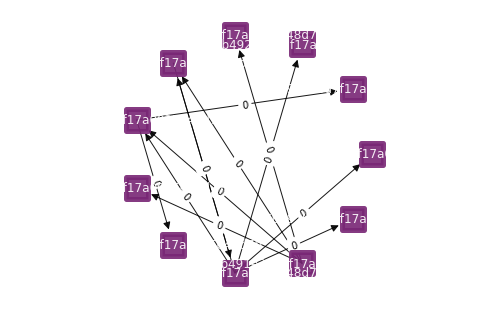

In [1068]:
class DrawNetwork(object):

    def __init__(self, G):
        self.graph = G
        
    def get_cardials(self):
        return nx.circular_layout(self.graph)
    
    
    def save_svg(self, options, labels):
        #plt.figure(figsize=(4, 4))
        pos = self.get_cardials()

        nx.draw(self.graph, pos, **options)

        labels = nx.get_edge_attributes(self.graph,'weight')
        nx.draw_networkx_edge_labels(self.graph,pos,edge_labels=labels)

        plt.axis('equal')
        plt.show()
    
options = {
    'with_labels': True,
    'arrowsize': 15,
    'node_shape': 's',
    'node_size': 500,
    'node_color': '#782675',
    'font_color': 'white',
    'alpha': 0.9,
    'linewidths': 5
}

labels = {
    'font_weight': 'bold'
}

draw = DrawNetwork(network.graph)
draw.save_svg(options, labels)

In [1069]:
G=network.graph
#nei = list(network.graph.neighbors('app1'))
#print(nei)

#network.graph.degree['app1']

#G.out_degree('app1')
#G.in_degree('app1')

In [1070]:
pagerank = nx.pagerank(G, alpha=0.9)
print(pagerank)

density = nx.density(G)
print(density)

hist = nx.degree_histogram(G)

{'5b492b0fd7f17a0025e48d80': 0.09090909090909094, '5b491e5bd7f17a0025e48d7c': 0.09090909090909094, '5b492b08d7f17a0025e48d7f': 0.09090909090909094, '5b491e4dd7f17a0025e48d7a': 0.09090909090909094, '5b491e48d7f17a0025e48d79': 0.09090909090909094, '5b491e45d7f17a0025e48d78': 0.09090909090909094, '5b491e43d7f17a0025e48d77': 0.09090909090909094, '5b491e54d7f17a0025e48d7b': 0.09090909090909094, '5b491e66d7f17a0025e48d7d': 0.09090909090909094, '5b492b04d7f17a0025e48d7e': 0.09090909090909094, '5b491e3dd7f17a0025e48d76': 0.09090909090909094}
0.10909090909090909


In [1071]:
import collections

class Histogram(object):
    def __init__(self):
        self._hist = None
        
    def set_collections(self, data):
        self._hist = collections.Counter(data)
        return self
        
    def get_counter(self):
        return dict(self._hist)
    
    def max_columm(self):
        if self._hist != None:
            return self._hist.most_common(1)[0]
    
    def max_value(self):
        n = self.max_columm()
        if n:
            return n[1]    
    
class GridHistogram(Histogram):
    def __init__(self, grid):
        super().__init__()
        self._grid = grid
        self.make()
    
    def make(self):
        clear = {}
        
        for key, value in self._grid.items():
            clear[key] = len(value)
   
        self.set_collections(clear)
        
class GraphHistogram(Histogram):
    
    def __init__(self, G):
        super().__init__()
        self._graph = G
        self.make()
    
    def find_weight(self, item, weight=0):
        weight = self._graph.nodes[item].get('weight')
        
        if not weight:
            pred = self._graph.in_edges(item, data=True)

            if pred and len(list(pred)) > 0:
                weight = max([it[2].get('weight') for it in pred]) + 1
        
        return weight

    def make(self):
        nodes = self._graph.nodes()
        weights = []
        
        for node in nodes:
            w = self.find_weight(node)
            weights.append(w)
    
        self.set_collections(weights)
 
        
GraphHistogram(G).get_counter()

{1: 10, None: 1}

In [1072]:
from svgwrite import Drawing

class DefsSVG(object):
    
    def __init__(self, draw):
        self.dwg = draw

    def app(self, pos, title, size=(20,20), unit="px"):
        opts = {
            'size': ("%s%s"%(size[0], unit), "%s%s"%(size[1], unit)),
            'stroke_width': "1",
            'stroke': "black",
            'fill': "rgb(255,255,0)"
        }
        
        self.add(self.dwg.rect(insert = pos, **opts))
        self.add(self.dwg.text(title, insert=(pos[0], pos[1]+10), fill='red'))
    
    def line(self, cx, cy):
        opts = {
            'stroke_width': "1",
            'stroke': "black",
            'fill': "rgb(0,0,0)"
        }
        
        self.add(self.dwg.line(start=cx, end=cy, **opts))
    
    def add(self, svg):
        self.dwg.add(svg)
        
class DrawArea(object):
    def __init__(self, off, size, hist, nmax):
        self._off = off
        self._size = size
        self._hist = hist
        self._nmax = nmax
        
    def cal_area(self, n, pointer):
        return (n * self._size[pointer]) + (n * self._off[pointer])
    
    def area(self):
        area_y = self.cal_area(self._nmax, 1)
        area_x = self.cal_area(max(self._hist, key=int) + 1, 1)
        return (area_x, area_y)
    
class DrawSVG(object):
    def __init__(self, hist, nmax, darea=DrawArea, draw=Drawing, defs=DefsSVG):
        self._off = (40, 40)
        self._size = (20, 20)
    
        self._hist = hist
        self._nmax = nmax
        
        self._area = darea(self._off, self._size, hist, nmax).area()
        
        self.dwg = Drawing('test.svg', size=self._area)
        self._grid_defs = defs(self.dwg)
    
    def draw_app(self, pos, w, label):
        pos = self.cal_off(pos, w)
        self._grid_defs.app(pos, label, self._size)
    
    def draw_connect(self, pos1, pos2, w1, w2):
        pos1 = self.cal_pos_line(pos1, w1, self._size[0])
        pos2 = self.cal_pos_line(pos2, w2)
        
        self._grid_defs.line(pos1, pos2)
   
    def cal_off(self, pos, w):
        x = self.cal_offx(pos[0], w)
        y = self.cal_offy(pos[1], w)
        
        return (x, y)
        
    def cal_offy(self, y, w):  
        off = 0
        #if self._hist[w] < self._nmax:
        #    off = (self._nmax - self._hist[w]) / 2
        #    off = off * (self._off[1] + self._size[1])
        
        return (y * self._off[1]) + (y * self._size[1]) + off 
    
    def cal_offx(self, x, w):
        return (x * self._off[0]) + (x * self._size[0])
    
    def cal_pos_line(self, pos, w, suff_x=0):
        apos = self.cal_off(pos, w)
        y = apos[1] + (self._size[1]/2)
        x = apos[0] + suff_x
        
        return (x, y)
    
    def save(self):
        self.dwg.save()
        
class DrawLayout(object):
    def __init__(self, grid, index, gridhist=GridHistogram, draw=DrawSVG):
        
        self._grid = grid
        self._index = index
        
        GridHistogram = gridhist(self._grid)
        self._nmax = GridHistogram.max_value()
        self._hist = GridHistogram.get_counter()
        
   
        self.drawer = draw(self._hist, self._nmax)

    def draw_nodes(self):
        data = self._grid
        for col_k, columm in data.items():
            for line_k, label in columm.items():
                if label in self._index:
                    item = self._index[label]
                    label = item[3].get('name')
                self.drawer.draw_app((col_k, line_k), col_k, label)
        
        return self
    
    def draw_connections(self, edges):
        for edge in edges:
            pos = []
            w = []
            
            for i in range(2):
                ipos = self._index[edge[i]]
                pos.append(ipos)
                w.append(ipos[0])

            self.drawer.draw_connect(*pos, *w)
            
        return self 
    
    def save(self):
        self.drawer.save()

In [1073]:
class Grid(object):
    def __init__(self):
        self.clean()
        self._dmark = '-'
    
    def get_grid(self):
        return self._grid
    
    def has_pos(self, x, y):
        return (x in self._grid) and (y in self._grid[x])
    
    def get_pos(self, x, y, deft=None):
        if self.has_pos(x, y):
            return self._grid[x][y]
        
        return deft 
    
    def in_grid(self, step):
        return step in self._grid
    
    def not_in_grid(self, step):
        return step not in self._grid
    
    def max_y(self, step):
        return max(self._grid[step], key=int)
    
    def max_x(self):
        return max(self._grid, key=int)
    
    def _add_grid(self, x, y, item):
        if x not in self._grid:
            self._grid[x] = {}
            
        self._grid[x][y] = item
        return (x, y)
    
    def del_grid(self, columm, line):
        del self._grid[columm][line]
        
    def clean(self):
        self._grid = {}
        self._index = {}
        
class GridMapSwift(object):
    def make_swift(self, node, loc, direct=0):
        pos = self.get_index(node)
        max_x = self.max_x()
        diff = loc - pos[0]
        
        for columm in range(max_x, pos[0]-1, -1):  
            end = pos[1]+pos[2]

            for line in range(pos[1], end):
                self.swift_update_line(columm, line, diff)         
                        
    def swift_update_line(self, columm, line, diff):
        if line in self._grid[columm]:
            ccnode = self.get_pos(columm, line)
            self.del_grid(columm, line)

            self.swift_update_node(ccnode, diff)
            
    def swift_update_node(self, ccnode, diff):
        if ccnode in self._index: 
            npos = self.get_index(ccnode)
            self.del_item(ccnode)

            self.create_position((npos[0]+diff, npos[1]), ccnode, npos[2])

class GridMapDummies(object):
    def create_dummy(self, pos):
        return self._add_grid(*pos, self._dmark)
    
class GridMap(Grid, GridMapSwift, GridMapDummies):
    
    def get_item_pos(self, item):
        if item in self._index:
            return self._index[item]
    
    def get_index(self, item=None):
        if item:
            return self._index.get(item)
        
        return self._index
    
    def is_node(self, x, y):
        return self.get_pos(x, y, self._dmark) != self._dmark
    
    def in_index(self, item):
        return item in self._index
                  
    def create_position(self, pos, label, size=1, attr={}):
        self.create_index(label, pos, size, attr)
        return self._add_grid(*pos, label)
    
    def create_index(self, label, pos, size, attr):
        self._index[label] = (*pos, size, attr)
        return pos, size
    
    def inc_size_index(self, anode, qtd=1):
        tmp = self.get_index(anode)
        self.update_index(anode, (tmp[0], tmp[1]), tmp[2]+qtd, tmp[3])
        
    def update_index(self, anode, pos, size, attr):
        self.del_item(anode)
        self.create_index(anode, pos, size, attr)
    
    def del_item(self, anode):
        del self._index[anode]

In [1074]:
class HelperDefineStep(object):
    def get_weight(self, node):
        dft = self._graph.nodes[node].get('weight')
        return self._get_weight(node, dft)
    
    def _get_weight(self, node, dft=0):
        if self._grid.in_index(node):
            idx = self._grid.get_index(node)
            return idx[0]
        
        return dft
    
    def get_node_attr(self, attr):
        return self._node.get(attr)
    
    def get_step(self):
        return self._step
    
    def make_step(self):
        node = self.get_id()

        if self._grid.in_index(node):
            idx = self._grid.get_index(node)
            return idx[0]

        return self.cal_step()
        
    def cal_step(self):
        predecessors = self.direct_predecessors()
        default_x = self.get_node_attr('weight')

        if len(predecessors) > 0:
            most = 0

            for pre in predecessors:
                wn = self._get_weight(pre)
                diff = wn - default_x

                if most < wn:
                    most = wn
                    
            default_x = most + 1
        return default_x

class HelperDefineSuccersPredecessors(object):
    def successors(self):
        return (self.only_direct_successors(), self.only_subdirect_successors())
    
    def only_direct_successors(self):
        self.categorize_successors()
        return self._direct_succers
    
    def only_subdirect_successors(self):
        self.categorize_successors()
        return self._subdirect_succers
    
    def only_direct_not_drawed(self, cat='direct'):
        self.categorize_successors()
        return self._succers_not_drawing.get(cat)
    
    def only_subdirect_not_drawed(self, cat='subdirect'):
        self.categorize_successors()
        return self._succers_not_drawing.get(cat)
    
    def categorize_successors(self):
        succers = set(self._graph.successors(self.get_id()))
        
        if (len(succers) > 0) and (not self._direct_succers):
            for node in succers:
                wg = self.get_weight(node)
                
                diff = wg - self._step
                self.grab_direct_succers(diff, node)
                self.grab_subdirect_succers(diff, node)
                
    def grab_direct_succers(self, diff, node):
        if (diff <= 1) and (node not in self._direct_succers):
            self._direct_succers.append(node)
            self.grab_not_drawing(node, 'direct')
    
    def grab_subdirect_succers(self, diff, node):
        if (diff > 1) and (node not in self._subdirect_succers):
            self._subdirect_succers.append(node)
            self.grab_not_drawing(node, 'subdirect')
            
    def grab_not_drawing(self, node, var):
        if not self._grid.in_index(node):
            self._succers_not_drawing[var].append(node)            
                
    def direct_predecessors(self):
        if not self._predecessors:
            self._predecessors = set(self._graph.predecessors(self.get_id()))
        
        return self._predecessors
    
    def grab_predecessors(self, node):
        return set(self._graph.predecessors(node))
    
class HelperDefineAttributes(HelperDefineStep, HelperDefineSuccersPredecessors):

    def __init__(self, node, grid, G):
        self._graph = G
        self._node = node
        self._grid = grid
        
        self._direct_succers = []
        self._subdirect_succers = []
        self._predecessors = []
        
        self._succers_not_drawing = {'direct': [], 'subdirect': []}
        
        self._step = self.make_step() 

    def get_attrs(self):
        return self.get_node_attr('attr')
    
    def get_id(self):
        return self.get_node_attr('uid')

    
class BasePattern(object):
    def __init__(self, grid, Helper):
        self._helper = Helper
        self._grid = grid
        self._step = self._helper.get_step()
        
        self._options = {
           'max_inter': 30
        }
        
    
    def _default_y(self):
        return self._max_empty_y(self._step)
        
    def _max_empty_y(self, step):
        if self._grid.not_in_grid(step):
            return 0
        
        return self._grid.max_y(step) + 1
    
    def find_next_node(self, y1, y2, step):
        found = False
        
        for it in range(y2, y1-1, -1):
            if self._grid.in_grid(step) and self._grid.is_node(step, it):
                found = self._grid.get_pos(step, it)
                break
                
        return found

class SinglePattern(object):
    def set_position(self):
        start_y = self._default_y()
        
        attr = self._helper.get_attrs()
        size = self.grow_node(start_y+1)
        self._grid.create_position((self._step, start_y), self._helper.get_id(), size, attr)

    def grow_node(self, start_y):
        size = 1
        succers = self._helper.only_direct_not_drawed()
        succers_size = len(succers)
        
        succers_size += self.chess_horse_growing(succers_size)
        
        if (succers_size >= 2):

            for ps in range(succers_size-1):
                nps = (self._step, start_y + ps)
                self._grid.create_dummy(nps)

            size = succers_size
            
        return size
    
    def chess_horse_growing(self, succers_size):
        subsuccers = self._helper.only_subdirect_successors()
        subdirect = len(subsuccers)
        
        sm = 0
        sm += 1 if (subdirect >= 1) and (succers_size == 0) else 0
        sm += 1 if subdirect >= 1 else 0
        return sm
        
class ChessHorsePattern(object):
    def chess_horse(self):
        succers = self._helper.only_subdirect_successors()
        
        if len(succers) >= 1:
            posy = self._max_empty_y(self._step)
            
            diff = 0
            for item in succers:
                w = self._helper.get_weight(item)
                switch_y = self.chess_horse_eligible_y(item, w)
                diff = ((w+switch_y) - self._step)
                
            self.chess_horse_dummie(diff, posy)
            self.balance_nodes(1)

    def chess_horse_dummie(self, diff, posy):
        for rg in range(diff):
            nstep = self._step + rg + 1
            
            if not self._grid.has_pos(nstep, posy):
                self._grid.create_dummy((nstep, posy))
    
    def chess_horse_eligible_y(self, label, w):
        diff = 0
        
        if self._grid.in_index(label):
            mypos = self._grid.get_index(label)
            start_search_y = mypos[1] + mypos[2]
            end_search_y = self._max_empty_y(w)

            nstep = self.chess_horse_recursive_y(start_search_y, end_search_y, mypos[0], label)
            diff = nstep - w

            if nstep != w:
                self._grid.make_swift(label, nstep)
            
        return diff
    
    def chess_horse_recursive_y(self, y1, y2, step, label):
        mx = step + 20
        while step <= mx:
            check = self.chess_horse_find_y(y1, y2, step, label)

            if check:
                break
            else:
                step += 1
                
        return step
    
    def chess_horse_find_y(self, y1, y2, step, node):
        last_node = self.find_next_node(y1, y2, step)
        return (last_node == False or last_node == node)


class ChessPawnPattern(object):
    
    def chess_pawn(self):
        is_root = self._helper.get_node_attr('root')
        step = self._helper.get_node_attr('weight')
        posy = self._default_y()
        
        if is_root and step > 0:
            self._grid.create_dummy((self._step, posy))
            self._step += 1
        
        
class BalancePattern(object):

    def soft_balance(self, step_pace=1):
        subsuccers = self._helper.only_subdirect_successors()
        succers = self._helper.only_direct_not_drawed()
        succers_size = len(succers+subsuccers)
        
        start_y = self._default_y()

        nstep = self._step + step_pace
        nposy = self._max_empty_y(nstep)
        
        if (succers_size > 0) and (start_y > nposy):
            diff = start_y - nposy
            for i in range(diff):
                posy = nposy + i
                self._grid.create_dummy((nstep, posy))
    
    def child_balance(self):
        succers = self._helper.only_direct_not_drawed()
        succers_size = len(succers)

        if succers_size >= 2:
            self.balance_nodes(succers_size-1)
    
    def balance_nodes(self, qtd):
        for nl in range(self._step):
            last = self._max_empty_y(nl)
            for np in range(qtd):
                posy = last + np
                self._grid.create_dummy((nl, posy))
    
            anode = self.find_next_node(0, last+1, nl)
            if anode:
                self._grid.inc_size_index(anode, qtd)
                
                
class IteratorMasterPattern(BasePattern, SinglePattern, BalancePattern, ChessHorsePattern, ChessPawnPattern):

    def map(self):
        return ['chess_pawn', 'chess_horse', 'soft_balance', 'child_balance', 'set_position']
        
    def find_rule(self):
        for check in self.map():
            getattr(self, check)() 

In [1075]:
from operator import itemgetter

class HelperOrderedSuccers(object):
    
    def __init__(self, helper):
        self._temp = []
        self._helper = helper
    
    def get_succers(self):
        subdirect = self._helper.only_subdirect_not_drawed()
        direct = self.make_sorted()
        return subdirect+direct
    
    def make_sorted(self):
        succers = self._helper.only_direct_not_drawed()
        
        for succer in succers:
            rating = self.find_rating(succer)
            self._temp.append((rating, succer))
                 
        ordered = sorted(self._temp, key=itemgetter(0))
        return [i[1] for i in ordered]
    
    def find_rating(self, succer):
        preds = self._helper.grab_predecessors(succer)
        
        rating = 0
        if len(preds) >= 2:
            for pred in preds:
                score = self.score(pred, self._helper.get_id())
                rating += score
        
        return rating
    
    def score(self, pred, ignore):
        sc = 0
        if (pred != ignore):
            
            if (self._helper._grid.in_index(pred)):
                sc = -1
            else:
                sc = 1
        
        return sc

class HelperSetupWeight(object):

    def __init__(self, G):
        super().__init__()
        self._graph = G

    def find_weight(self, item, weight=0):
        pred = self._graph.in_edges(item, data=True)

        if pred and len(list(pred)) > 0:
            weight = max([it[2].get('weight') for it in pred]) + 1

        return weight

    def setup(self):
        nodes = self._graph.nodes()
    
        for node in nodes:
            w = self.find_weight(node)
            self._graph.nodes[node]['weight'] = w

class GridOrchestrator(object):
    
    def __init__(self, G):
        self._graph = G
        self._grid = GridMap()
    
    def get_grid(self):
        return self._grid
    
    def create(self, entries):
        HelperSetupWeight(self._graph).setup()
        self._recursive_draw(entries)

    def add_pos_grid(self, node, CIterator=IteratorMasterPattern, CHelper=HelperDefineAttributes):
        Helper = CHelper(node, self._grid, self._graph)
        CIterator(self._grid, Helper).find_rule()
        
        return Helper
    
    def _recursive_draw(self, app, i=0):
        if i>30:
            return
        
        for item in app:
            if not self._grid.in_index(item):
                node = self._graph.nodes[item]
                helper = self.add_pos_grid(node)

                succ = HelperOrderedSuccers(helper).get_succers()
                self._recursive_draw(succ, i+1)

-------------------------


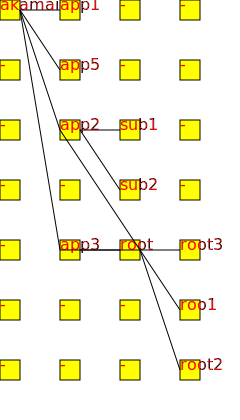

In [1076]:
from IPython.display import SVG, display

print("-------------------------")
Orchestration = GridOrchestrator(G)
Orchestration.create(entries)

Layout = DrawLayout(Orchestration.get_grid().get_grid(), Orchestration.get_grid().get_index())
Layout.draw_nodes()
Layout.draw_connections(G.edges(data='endpoint'))
Layout.save()

#print(Orchestration.get_grid().get_grid())
#print(Orchestration.get_grid()._index)
#print(G.edges(data='endpoint'))
   
display(SVG(filename='test.svg'))